<a href="https://colab.research.google.com/github/Kush-Singh-26/Learning-Pytorch/blob/main/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms as transforms

In [3]:
import random
import numpy as np
def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's built-in random module
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's random number generator

    if torch.cuda.is_available():  # Check if a CUDA-enabled GPU is available
       torch.cuda.manual_seed(seed)  # Set the seed for CUDA (single GPU)
       torch.cuda.manual_seed_all(seed)  # Set the seed for CUDA (multiple GPUs)
       torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
       torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN (can improve performance)

set_seed(42)

In [4]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [5]:
!unzip -q "10_Monkey_Species.zip"

In [6]:
from dataclasses import dataclass

In [7]:
@dataclass(frozen=True)
class TrainingConfig:
  batch_size: int = 32
  num_epochs: int = 20
  learning_rate: float = 1e-4

  log_interval: int = 1  # Interval at which to log training progress
  test_interval: int = 1  # Interval at which to test model performance
  data_root: int = "./"  # Path to dataset storage
  num_workers: int = 5  # Number of worker processes for data loading
  device: str = "cuda"

train_config = TrainingConfig()

@dataclass(frozen=True)  # Creating an immutable dataclass for training configuration
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32  # Number of samples per training batch
      num_epochs: int = 20  # Number of epochs (full passes through dataset)
      learning_rate: float = 1e-4  # Learning rate for optimizer

      log_interval: int = 1  # Interval at which to log training progress
      test_interval: int = 1  # Interval at which to test model performance
      data_root: int = "./"  # Path to dataset storage
      num_workers: int = 5  # Number of worker processes for data loading
      device: str = "cuda"  # Default device for training (CUDA if available)

train_config = TrainingConfig()

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cuda


In [8]:
import os

In [9]:
train_root = os.path.join("10_Monkey_Species", "training", "training")

val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")

In [10]:
import pandas as pd

df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)

df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]

df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")

df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [11]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

img_size = (224, 224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [12]:
common_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean=mean, std=std)
    ]
)

train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(p=0.4),

        transforms.RandomApply([
            transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        ], p=0.1),

        transforms.Normalize(mean=mean, std=std)
    ]
)

In [13]:
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [14]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [15]:
len(train_data)

1097

In [16]:
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=train_config.batch_size,
    num_workers=train_config.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle=False,
    batch_size=train_config.batch_size,
    num_workers=train_config.num_workers
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

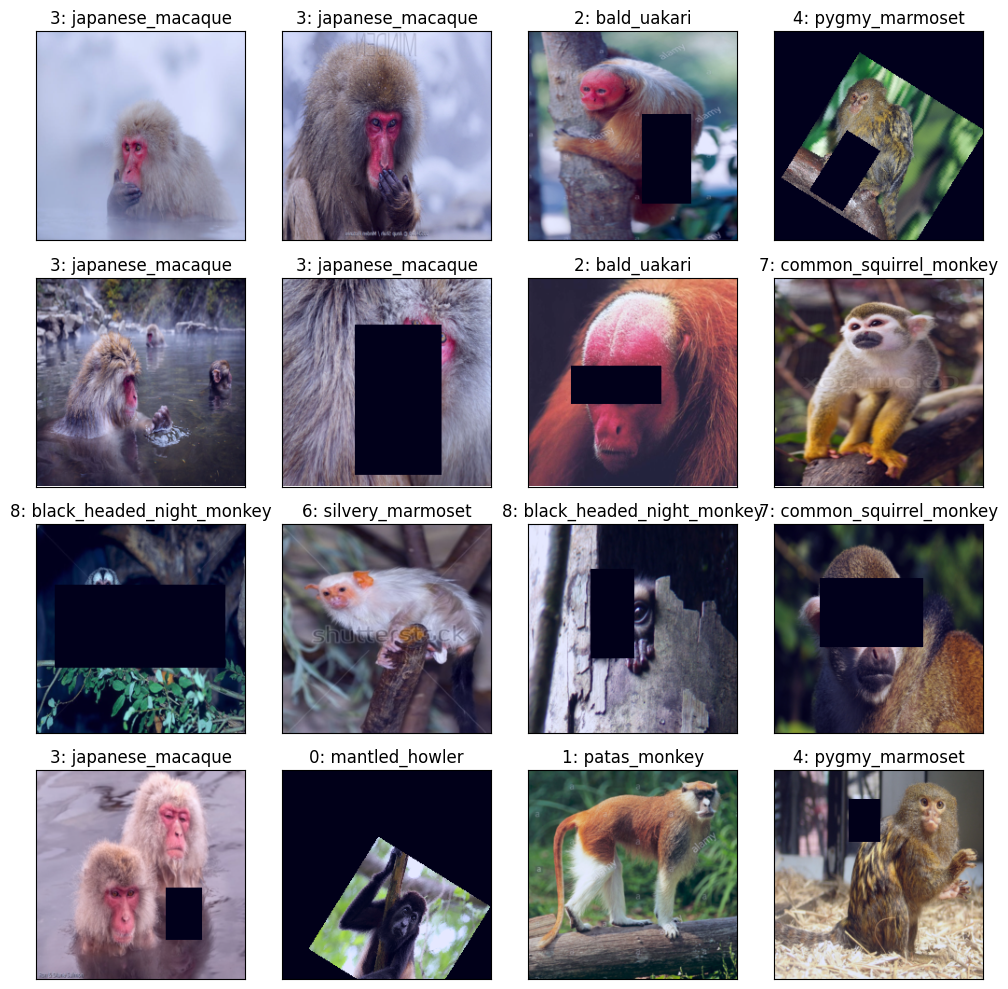

In [18]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization
import numpy as np  # Importing NumPy for numerical operations

def visualize_images(dataloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))  # Create a figure with a specified size

    # Retrieve the first batch from the DataLoader
    images, labels = next(iter(dataloader))

    num_rows = 4  # Define number of rows in the grid
    num_cols = int(np.ceil((num_images / num_rows)))  # Compute number of columns

    for idx in range(min(num_images, len(images))):  # Loop through the images up to num_images
        image, label = images[idx], labels[idx]  # Extract image and label

        ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])  # Create subplot

        image = image.permute(1, 2, 0)  # Reorder dimensions for visualization (C, H, W) → (H, W, C)

        # Normalize the image to [0,1] for display
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # Display the image
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")  # Set title with label info

    fig.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the figure

# Call the function to visualize a sample of images from the training dataset
visualize_images(train_loader, num_images=16)

In [19]:
from torchvision.models import mobilenet_v3_small

# Load the model
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

# Number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# Number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 71.8MB/s]

Number of feature layers: 13
Number of classifier layers: 4


Freeze the earlier layers to retain pretrained low-level features

In [20]:
for param in mobilenetv3_model.features[:10].parameters():  # Adjust as needed
    param.requires_grad = False

In [21]:
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


replace the final layer of classsifier to match number of classes in dataset

In [22]:
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 10, bias = True)

print(mobilenetv3_model.classifier[3])

model = mobilenetv3_model

Linear(in_features=1024, out_features=10, bias=True)


In [23]:
!pip install torchinfo

In [24]:
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

In [25]:
optimizer = Adam(model.parameters(), lr=train_config.learning_rate)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/mobilenetv3-Monkey-Species"

writer = SummaryWriter(logdir)

summary(model, input_size=(1, 3, 224, 224), row_settings=["var_names"], device="cpu")

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

In [26]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def train(model, train_loader):
    """
    Trains the model for one epoch using the provided training data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for training data.

    Returns:
    tuple: Average training loss and training accuracy.
    """
    model.train()  # Set the model to training mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_train_samples = 0  # Counter for total training samples

    # Iterate through the training data
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(images)  # Forward pass to get predictions
        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_train_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    train_avg_loss = running_loss / len(train_loader)  # Compute average loss
    train_accuracy = 100 * correct_predictions / total_train_samples  # Compute accuracy percentage
    return train_avg_loss, train_accuracy  # Return loss and accuracy

In [27]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def validation(model, val_loader):
    """
    Evaluates the model performance using the provided validation data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Average validation loss and validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_val_samples = 0  # Counter for total validation samples

    # Iterate through the validation data
    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device

        with torch.no_grad():  # Disable gradient computation for efficiency
            outputs = model(images)  # Forward pass to get predictions

        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_val_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    val_avg_loss = running_loss / len(val_loader)  # Compute average loss
    val_accuracy = 100 * correct_predictions / total_val_samples  # Compute accuracy percentage
    return val_avg_loss, val_accuracy  # Return loss and accuracy

In [28]:
import torch  # Importing PyTorch for model saving

def main(model, train_loader, val_loader):
    """
    Trains and validates the model over multiple epochs.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained and validated.
    train_loader (DataLoader): The DataLoader for training data.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Lists of training and validation losses and accuracies.
    """
    train_losses, val_losses = [], []  # Lists to store loss values for training and validation
    train_accuracies, val_accuracies = [], []  # Lists to store accuracy values for training and validation

    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_weights = None  # Store the best model weights

    # Training loop for the number of epochs specified in train_config
    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)  # Perform training for one epoch
        val_loss, val_accuracy = validation(model, val_loader)  # Perform validation for one epoch

        # Append losses and accuracies to the respective lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training progress
        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")  # Save model weights to a file

    return train_losses, train_accuracies, val_losses, val_accuracies  # Return training and validation metrics

In [29]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Training:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 01/20 - Train Loss: 2.0756, Train Accuracy: 33.00% - Val Loss: 1.5016, Val Accuracy: 66.54%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 02/20 - Train Loss: 1.4599, Train Accuracy: 68.28% - Val Loss: 0.8675, Val Accuracy: 77.94%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 03/20 - Train Loss: 0.9788, Train Accuracy: 78.85% - Val Loss: 0.5114, Val Accuracy: 87.87%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 04/20 - Train Loss: 0.6910, Train Accuracy: 82.41% - Val Loss: 0.3746, Val Accuracy: 92.28%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 05/20 - Train Loss: 0.5189, Train Accuracy: 87.88% - Val Loss: 0.2894, Val Accuracy: 93.01%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 06/20 - Train Loss: 0.4237, Train Accuracy: 87.88% - Val Loss: 0.2385, Val Accuracy: 94.49%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 07/20 - Train Loss: 0.3375, Train Accuracy: 91.43% - Val Loss: 0.1998, Val Accuracy: 96.69%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 08/20 - Train Loss: 0.3023, Train Accuracy: 92.07% - Val Loss: 0.1673, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 09/20 - Train Loss: 0.2934, Train Accuracy: 92.25% - Val Loss: 0.1478, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 10/20 - Train Loss: 0.2438, Train Accuracy: 92.53% - Val Loss: 0.1384, Val Accuracy: 95.59%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 11/20 - Train Loss: 0.2344, Train Accuracy: 93.35% - Val Loss: 0.1270, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 12/20 - Train Loss: 0.2146, Train Accuracy: 93.80% - Val Loss: 0.1166, Val Accuracy: 97.06%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 13/20 - Train Loss: 0.1928, Train Accuracy: 93.89% - Val Loss: 0.1142, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 14/20 - Train Loss: 0.2096, Train Accuracy: 94.17% - Val Loss: 0.1104, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 15/20 - Train Loss: 0.1803, Train Accuracy: 94.44% - Val Loss: 0.1016, Val Accuracy: 97.43%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 16/20 - Train Loss: 0.1803, Train Accuracy: 94.80% - Val Loss: 0.0988, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 17/20 - Train Loss: 0.1574, Train Accuracy: 94.90% - Val Loss: 0.0987, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 18/20 - Train Loss: 0.1451, Train Accuracy: 95.72% - Val Loss: 0.1010, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 19/20 - Train Loss: 0.1355, Train Accuracy: 95.53% - Val Loss: 0.0947, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

Epoch 20/20 - Train Loss: 0.1511, Train Accuracy: 94.90% - Val Loss: 0.0936, Val Accuracy: 96.69%


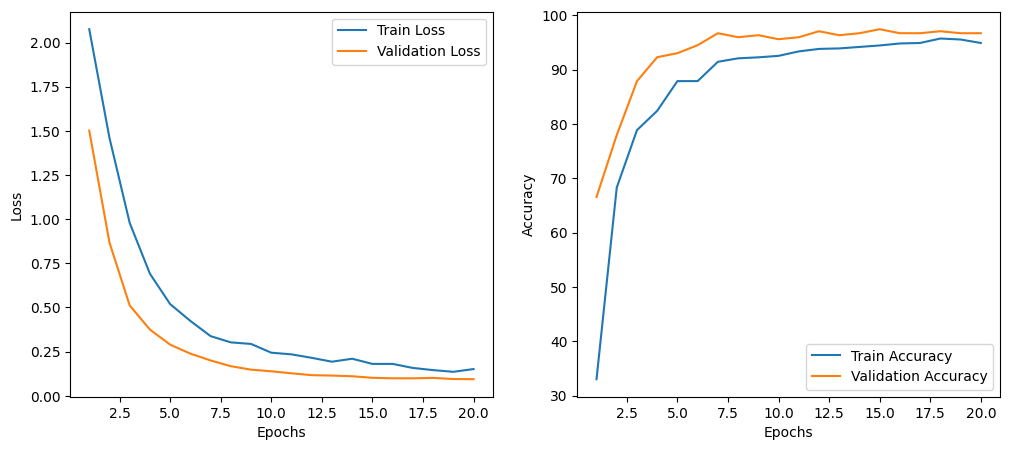

In [30]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization

# Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Plot training and validation loss over epochs
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(range(1, train_config.num_epochs + 1), train_losses, label="Train Loss")  # Plot train loss
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label="Validation Loss")  # Plot validation loss
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

# Plot training and validation accuracy over epochs
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label="Train Accuracy")  # Plot train accuracy
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")  # Plot validation accuracy
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

plt.show()  # Display the plots

In [31]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [32]:
def prediction(model, val_loader):

    model.eval()  # Set the model to evaluation mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    all_images, all_labels = [], []  # Lists to store images and true labels
    all_pred_indices, all_pred_probs = [], []  # Lists to store predicted labels and probabilities

    # Iterate over the validation dataset
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to selected device

        with torch.inference_mode():  # Disable gradient calculations for efficiency
            outputs = model(images)  # Forward pass to get predictions

        prob = F.softmax(outputs, dim=1)  # Convert outputs to probabilities using softmax
        pred_indices = prob.data.max(dim=1)[1]  # Get predicted class index
        pred_probs = prob.data.max(dim=1)[0]  # Get corresponding prediction confidence

        all_images.append(images.cpu())  # Move images back to CPU and store
        all_labels.append(labels.cpu())  # Move labels back to CPU and store
        all_pred_indices.append(pred_indices.cpu())  # Store predicted indices
        all_pred_probs.append(pred_probs.cpu())  # Store predicted probabilities

    return (
        torch.cat(all_images).numpy(),  # Convert list of images to NumPy array
        torch.cat(all_labels).numpy(),  # Convert list of labels to NumPy array
        torch.cat(all_pred_indices).numpy(),  # Convert list of predicted labels to NumPy array
        torch.cat(all_pred_probs).numpy()  # Convert list of prediction probabilities to NumPy array
    )

In [34]:
def denormalize(image):
    mean_ar = np.array(mean)  # Convert mean list to NumPy array
    std_ar = np.array(std)  # Convert standard deviation list to NumPy array

    image = image * std_ar + mean_ar  # Reverse normalization transformation
    return np.clip(image, 0, 1)

In [35]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=5):

    fig = plt.figure(figsize=(20, 5))  # Create a figure with specified size

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)  # Select a random index
        image = sample_images[idx].transpose(1, 2, 0)  # Convert (C,H,W) to (H,W,C) for display
        label = sample_gt_labels[idx]  # Get the ground truth label
        pred_idx = pred_indices[idx]  # Get the predicted class index
        pred_prob = pred_probs[idx]  # Get the corresponding prediction confidence

        image = denormalize(image)  # Denormalize the image for proper visualization

        ax = fig.add_subplot(1, num_images, i + 1)  # Create a subplot
        ax.imshow(image)  # Display the image
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")  # Set title
        ax.axis('off')  # Remove axis labels for better display

    plt.show()  # Display the figure

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


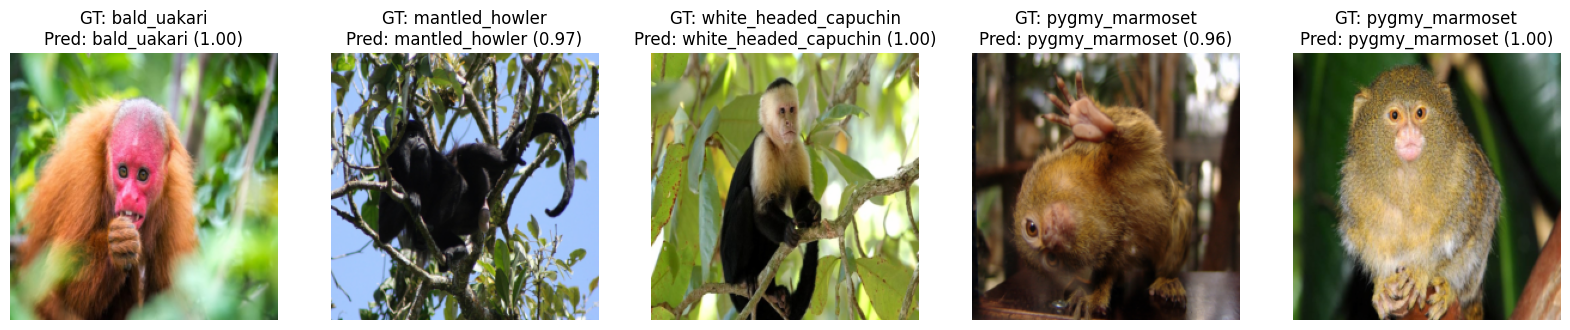

In [36]:
# Generate predictions using the trained model on the validation dataset
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

# Visualize a subset of the predictions
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)